# EDA

In [432]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [433]:
df = pd.read_csv("./ACME-HappinessSurvey2020.csv")
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [434]:
# Describe the main data stats
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [435]:
# Check for any null values
df.isnull().any().any()

False

We now take a look at the graphical relationship between the individual features and the target variable.

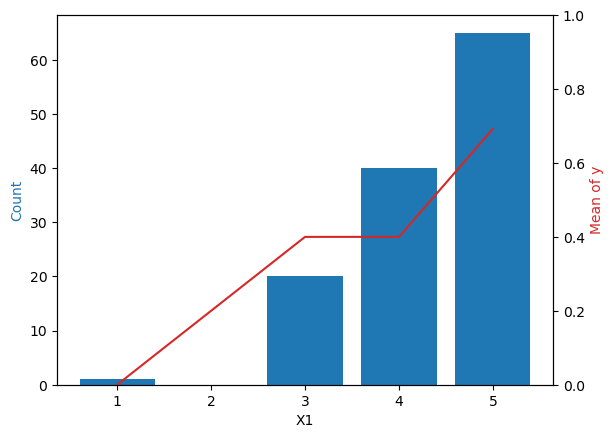

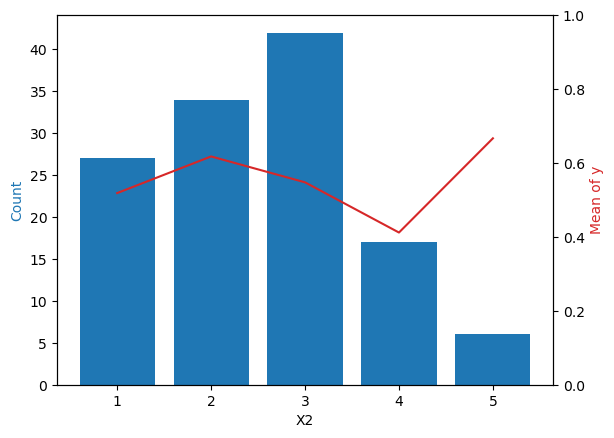

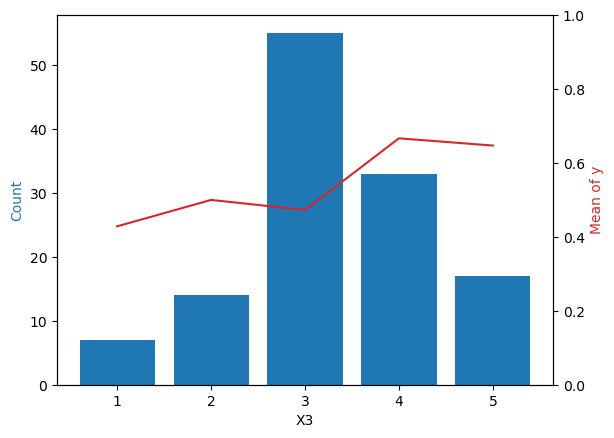

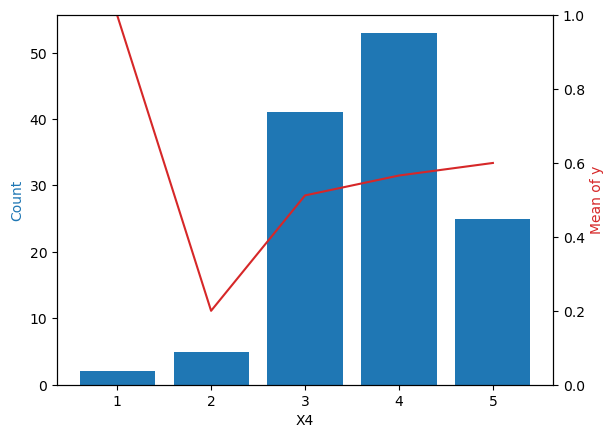

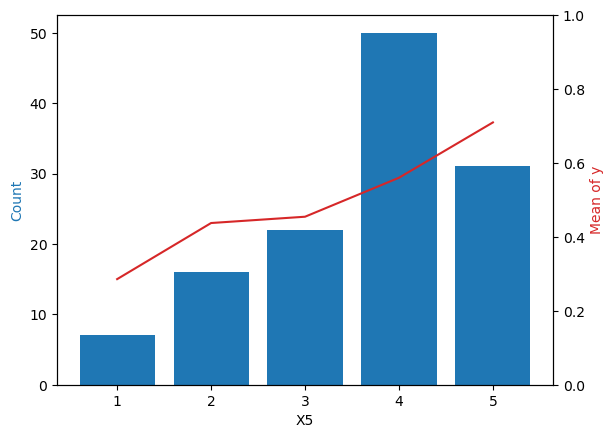

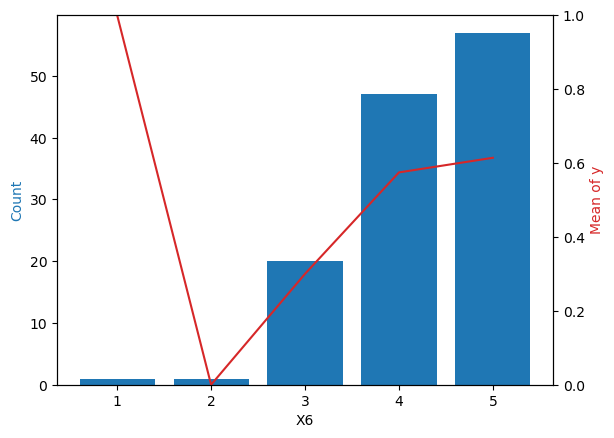

In [436]:
for i in range(1, 7):
    fig, ax = plt.subplots()
    var = f"X{i}"
    xi_avg = df.groupby(var).agg(mean_y=('Y', 'mean'), count_x=(var, 'count'))
    color = 'tab:blue'
    ax.set_xlabel(var)
    ax.set_ylabel('Count', color=color)
    ax.bar(xi_avg.index, xi_avg.count_x, color=color)
    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean of y', color=color)
    ax2.plot(xi_avg.index, xi_avg.mean_y, color=color)
    ax2.set_ylim([0,1])
    plt.show()

We can see that $X_4$ exhibits strange erratic behaviour, dropping significantly between the values of 1 and 2. It therefore might not be the best variable to include as a feature as it may provide only noise. We will keep it in and let the feature importances decide its effectiveness.

Summarising the data where the review was positive and negative

In [437]:
X, y = df.drop(["Y"], axis=1), df["Y"]
X_pos = X.loc[y == 1]
X_neg = X.loc[y == 0]


In [438]:
X_pos.describe()

,X1,X2,X3,X4,X5,X6
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,4.536232,2.507246,3.449275,3.797101,3.884058,4.376812
std,0.698311,1.106441,1.022342,0.900649,1.064621,0.768908
min,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,5.000000,2.000000,3.000000,4.000000,4.000000,5.000000
75%,5.000000,3.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [439]:
X_neg.describe()

,X1,X2,X3,X4,X5,X6
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,4.087719,2.561404,3.140351,3.684211,3.368421,4.105263
std,0.851064,1.134170,1.007802,0.848484,1.189712,0.838455
min,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
25%,4.000000,2.000000,3.000000,3.000000,3.000000,3.000000
50%,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Would have expected the mean vals for all of the variables to be higher for the positive reviews given the questions but `X2` is actually lower. We also note that the classes are *slightly* imbalanced, with slightly more observbations with a target = 1. While the required metric for satisfaction is accuracy, it would be worth considering others which capture the model's performance nonwithstanding the class imbalance such as AUC, F1 etc.

In [440]:
X_pos.mean() - X_neg.mean()

X1    0.448513
X2   -0.054157
X3    0.308924
X4    0.112891
X5    0.515637
X6    0.271548
dtype: float64

In [441]:
# Compute the correlation matrix to observe dependence between vars
df.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


From the matrix, we observe that the $X_2$ variable has little to no correlation to the target $y$, so we may consider dropping that column from the feature set to improve performance and reduce noise. We may consider the same for $X_4$. None of the variables have an excessively low variance which would indicate that they do not change even slightly and may not be a good predictor. Variables $X_3, X_5$ have the highest correlation of all of the pairs. A high corelation between two input variables could indicate that there may be some relationship or dependence between them and that one of them is then only providing noise, but in this case the number is not very high. It however may be worth experimenting with dropping the $X_3$ variable to see if that improves performance, as it has a lower correlation with the target.

In [442]:
# X_prime = X
X_prime = X.drop(['X2', 'X4'], axis=1)
X_prime.head()

,X1,X3,X5,X6
0,3,3,2,4
1,3,3,4,3
2,5,3,3,5
3,5,3,3,5
4,5,3,3,5


Splitting the data into train test split and using K Fold cross validation to examine the performance of some preliminary classification models before any hyperparameter or feature selection / tuning

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X_prime, y, random_state=3)
kf = KFold(n_splits=5)
models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')]
for model in models:
    res = cross_val_score(model, X_train, y_train, scoring="accuracy", cv = kf)
    print(res.mean())

0.47894736842105257
0.6269005847953217
0.6497076023391812


XGBoost model consistently outperforms others as a baseline on accuracy. Continuing with this model to try and refine using some basic hyperparameter tuning using an estimator size of 1000 and trying to find the best depth and child weight using cross validation.

In [444]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=27),
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.6221969696969698)

Fir the model with the best parameters and evaluate the trainnig accuracy and the test accuracy.

In [445]:
model = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=gsearch1.best_params_['max_depth'],
 min_child_weight=gsearch1.best_params_['min_child_weight'], gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=27)
model.fit(X_train, y_train)
print(f"Training Accuracy: {model.score(X_train, y_train)}")
print(f"Test Accuracy: {model.score(X_test, y_test)}")

Training Accuracy: 0.8404255319148937
Test Accuracy: 0.75


Create the classification report on the test set to evaluate the perfomance of the model on the test set. The precision for the positive class is low and its recall high, indicating the model is more likely to assign a positive label to a prediction. However in this example there are more observations in the negative class than in the positive and as there are so few in total, it skews the results a little.

In [446]:
y_pred = model.predict(X_test)
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       0.68      0.94      0.79        16

    accuracy                           0.75        32
   macro avg       0.79      0.75      0.74        32
weighted avg       0.79      0.75      0.74        32

Confusion Matrix
[[ 9  7]
 [ 1 15]]


The XGBoost model gives us feature importance measures. Here we can check to make sure that there are not features which are outweighing everything else and none that are insignificantly important.

In [447]:
model.feature_importances_

array([0.27596724, 0.23914725, 0.22696552, 0.25792003], dtype=float32)

Finally we plot the same as in the beginning on the test set, with both the true y and the predicted y to make sure the distributions are not too divergent.

In [448]:
X_test.insert(0, "y_true", y_test)
X_test.insert(0, "y_pred", y_pred)


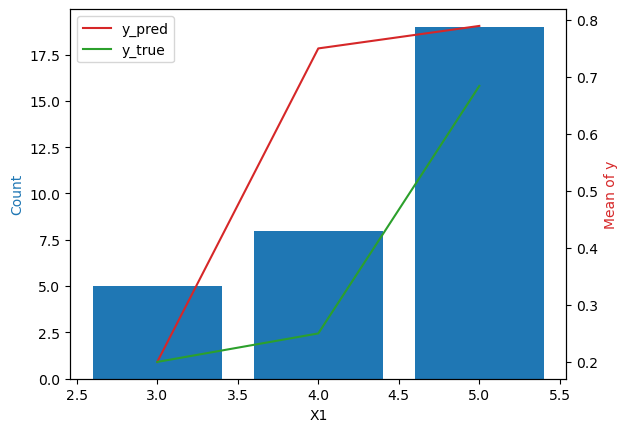

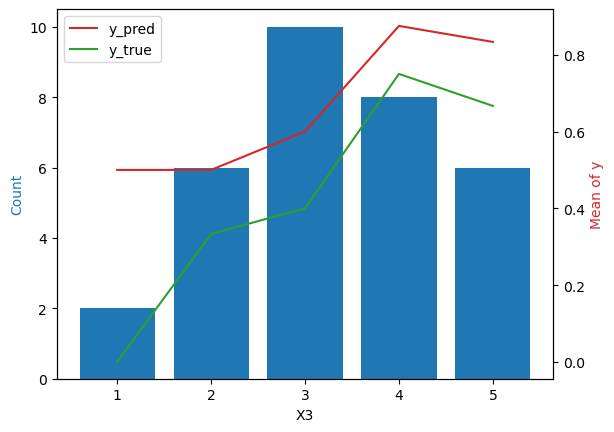

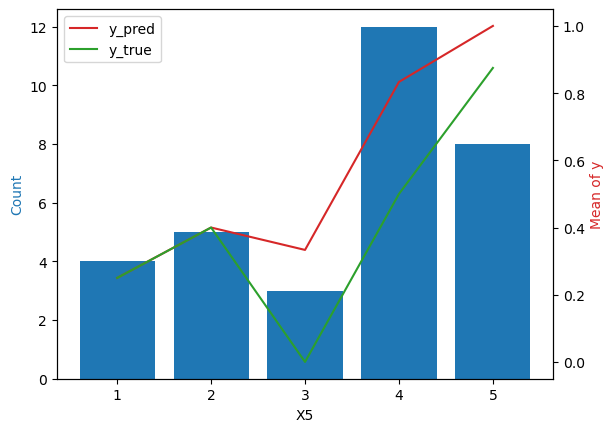

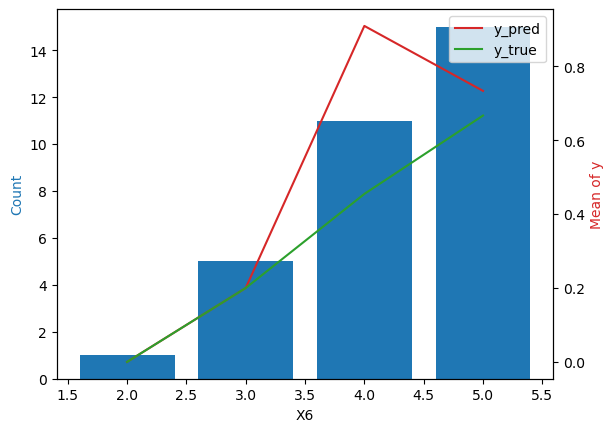

In [449]:
for var in X_test.columns[2:]:
    fig, ax = plt.subplots()
    xi_avg = X_test.groupby(var).agg(mean_y_pred=('y_pred', 'mean'), mean_y_true=('y_true', 'mean'), count_x=(var, 'count'))
    color = 'tab:blue'
    ax.set_xlabel(var)
    ax.set_ylabel('Count', color=color)
    ax.bar(xi_avg.index, xi_avg.count_x, color=color)
    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean of y', color=color)
    ax2.plot(xi_avg.index, xi_avg.mean_y_pred, color=color, label="y_pred")
    ax2.plot(xi_avg.index, xi_avg.mean_y_true, color='tab:green', label="y_true")
    ax2.legend()
    plt.show()

# Conclusion

The steps taken in this project were as follows:

First, we proceeded with some EDA, taking a look at the distribution of the data, and the relationships of the individual features of the dataset to the target variable. here we noticed in paticular the $X_4$ has a slightly erratic relationship and in fact is the only feature with a mean that is lower for targets in the positive class. Then we looked at the correlation matrix to ensure that there were not any features that were at risk of being dependent, thus one of them only produces noise and this was not the case. next, we split the data into a train and test set, and evalauated the performance of some binary classification models on the train set to achieve some idea of baseline numbers. Having decided that XGBoost was the way to proceed, we performed some basic hyperparameter tuning using cross validation over the train set to get the best version of this model. Finally, we applied the model to the test set and evaluated its perfomance using the classification report metrics of precision, recall, auc and the confusion matrix to examine closer the effect of false positives and negatives on the classification as opposed to pure accuracy. As a further diagnostic measure, we produced plots of the test features against the target variable, as well as the mean of the true and predicted y to make sure the distributions of both did not deviate systemically.

As the dataset was quite small, there is a high degree of variability in the results due to the random train test split. We achieve a test accuracy that varies from around 0.59 - 0.84. The small test set also meand the classification report is not that indicative, as there are very few samples of each. This is also the case in training, where we observe some features having little to no examples of a particular value. By setting the random seed in this instance we can obtain a fixed accuracy of 0.75, but this number is quite unreliable for reasons just explained.